In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import datetime, timedelta, date
from sympy import symbols, solve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

## SIRD model in Python 

In [2]:
# SIRD model divided into its equations
def deriv(y, t, N, beta, gamma, rho):
    S, I, R, D= y
    dSdt = -(beta * S * I) / N
    dIdt = ((beta * S * I) / N) - ((gamma+rho)*I)
    dRdt = gamma * I
    dDdt = rho * I
    return dSdt, dIdt, dRdt, dDdt

## Graph SIRD model

In [3]:
def getSIRD(tf, N, i0, beta, gamma, rho, sd):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T


    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 

    return S,I,R,D

In [4]:
import math
def plotSIRD(ax, tf, N, i0, beta, gamma, rho, ylimit, xlimit, sd, offset, sird_true):
    t = np.linspace(0, tf, tf)

    y0 = N-i0, i0, 0, 0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, rho))
    S, I, R, D = ret.T

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta-sd[0], gamma-sd[1], rho-sd[2]))
    Sm, Im, Rm, Dm = ret.T 

    # SD SIR equation
    ret = odeint(deriv, y0, t, args=(N, beta+sd[0], gamma+sd[1], rho+sd[2]))
    Sp, Ip, Rp, Dp = ret.T 


    # Plotting SIRD data point
    if (sird_true):
        ax.plot(t+offset, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t+offset, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t+offset, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.plot(t+offset, D, 'y', alpha=0.5, lw=2, label='Deceased')
    else:
        ax.plot(t+offset, D, alpha=1, lw=2, label='Deceased')


    # Creating Labels for graph
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Deceased')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    ax.set_xlim([xlimit[0], xlimit[1]])
    ax.set_ylim([ylimit[0], ylimit[1]])
    ax.fill_between(t+offset, Dm, Dp, alpha=0.2, edgecolor='black',  label="Standard Deviation")
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    return D
    

In [5]:
def plotRealData (graph, data, offset, beforeForecast, D, minus, manipulate=False):
    if (manipulate==False):
        deaths = data["cumDeath"].tolist()
        deaths = [x-minus for x in deaths]
    else:
        deaths = data["cumDeath"]-data["cumDeath"].loc[offset]
        deaths = deaths.to_list()
        deaths = [x+minus for x in deaths]
    t = np.linspace(0, 700, 700)
    if (offset != 0):
        graph.plot(t[0:offset], deaths[0:offset], 'r', marker='.', linestyle = 'None')
        graph.plot(t[offset:beforeForecast], deaths[offset:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    else:
        graph.plot(t[0:beforeForecast], deaths[0:beforeForecast], 'r', marker='x', label="Observed Data", linestyle = 'None')
        graph.plot(t[beforeForecast:len(t)], deaths[beforeForecast:len(t)], 'r', marker='.', label="Unseen Data", linestyle = 'None')
    legend = graph.legend()
    legend.get_frame().set_alpha(0.5)
    return graph
    

## Bulk 

In [6]:
def addTime(startDate, t): 
    dates = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = dates+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')
def timeTot(startDate, endDate):
    sD = startDate.split('-')
    sDs = date(int(sD[0]),int(sD[1]),int(sD[2]))
    eD = endDate.split('-')
    eDs = date(int(eD[0]),int(eD[1]),int(eD[2]))
    delta = eDs - sDs
    return delta.days

In [7]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-11-03','2021-02-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           },
    'Netherlands' : {
        'data' : pd.read_csv("../processed_data/cumDeathNetherlands.csv"),
        'fLock' : ['2020-03-15', '2020-04-06'],
        'sLock' : ['2020-12-15', '2021-06-05'],
        'pop' : 17606800
            }
}


### Testing MCMC model with ODE SIRD

In [8]:
import math
N = 60000000
i0 = 300
s0 = N-i0
beta = 0.03
gamma = 0.04
rho = 0.11
time = 0
k = i0/s0
# Integrate the SIR equations over the time grid, t.
solution = 0
for time in range(100):
    solution += rho*(i0*(1+k)**(beta/(beta-(gamma)))*(1+k*math.e**(beta-(gamma+rho))*time)**-(beta/(beta-(gamma+rho)))*math.e**((beta-(gamma+rho))*(time)))

print(getSIRD(100,60000000,300,0.03,0.04,0.11,[0.01,0.03,0.04])[3][1])
print(solution)

31.39233857398158
291.82628766288883


## First Lockdown

### Goodness of Fit

In [13]:

country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_observed_data = dataset[country]['data']
    df_parameters = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]
    # Get the index of the date
    startDate = df_observed_data[df_observed_data['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    obs_deaths = df_observed_data["cumDeath"].tolist()
    init_death = obs_deaths[startDate[0]-6]
    obs_deaths = obs_deaths[startDate[0]-5:startDate[0]+5]

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(60,pop, df_parameters.loc[3][1],df_parameters.loc[0][1],df_parameters.loc[1][1],df_parameters.loc[2][1], [df_parameters.loc[0][2], df_parameters.loc[1][2], df_parameters.loc[2][2]] )


    pred_deaths = sird[3]
    pred_deaths = pred_deaths[0:10] + init_death

    r2 = r2_score(obs_deaths, pred_deaths)
    rmse =  np.sqrt(mean_squared_log_error(obs_deaths, pred_deaths))

    n = len(obs_deaths)
    k = 4 # number of parameters (beta and gamma)
    rss = np.sum((obs_deaths-pred_deaths)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.973996,0.186590,34.908675
1,France,0.933471,0.214592,82.785331
2,Germany,0.985293,0.145030,60.998106
3,Italy,-0.228533,0.863708,128.774173
4,Spain,0.968309,0.288853,79.776905
5,UK,0.986377,0.107648,96.282107


In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_squared_log_error

country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
values = []
for country in country_names:
    pop = dataset[country]['pop']
    df_real = dataset[country]['data']
    df_param = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")

    # Get beginning of lockdown date
    startDate = dataset[country]['fLock'][0]

    # Get the index of the date
    startDate = df_real[df_real['date'] == startDate].index

    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']

    # Plug in parameters to the SIRD differential equation
    sird = getSIRD(30,pop, df_param.loc[3][1],df_param.loc[0][1],df_param.loc[1][1],df_param.loc[2][1], [df_param.loc[0][2], df_param.loc[1][2], df_param.loc[2][2]] )

    deaths = df_real["cumDeath"].tolist()
    deaths = deaths[startDate[0]-5:startDate[0]+15]
    
    deaths_predicted = sird[3]
    deaths_predicted = deaths_predicted[0:20]
    
    r2 = r2_score(deaths, deaths_predicted)
    rmse =  np.sqrt(mean_squared_log_error(deaths, deaths_predicted))

    n = len(deaths)
    k = 4 # number of parameters (beta and gamma)
    rss = np.sum((deaths-deaths_predicted)**2)
    aic = n * np.log(rss/n) + 2 * k
    result = [country,r2,rmse,aic]
    values.append(result)
df = pd.DataFrame(values, columns=['Country','R-Squared (R2)','Root Mean Squared Error (RMSE)','AIC'])
df

,Country,R-Squared (R2),Root Mean Squared Error (RMSE),AIC
0,Netherlands,0.952996,0.559479,164.144106
1,France,0.914704,0.931712,237.954318
2,Germany,0.952040,0.824250,210.148500
3,Italy,0.487730,1.364399,295.274092
4,Spain,0.952992,0.862913,246.952362
5,UK,0.966102,1.283226,267.227085


### Graph

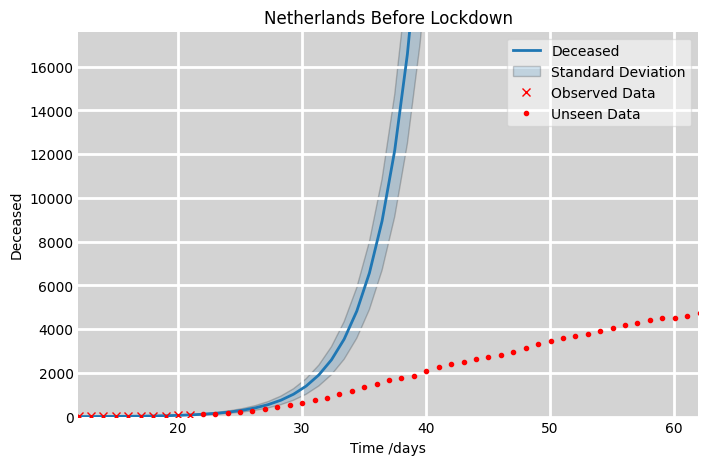

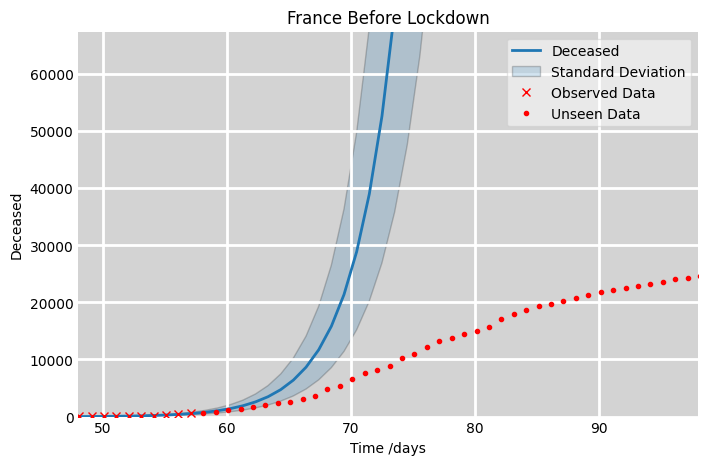

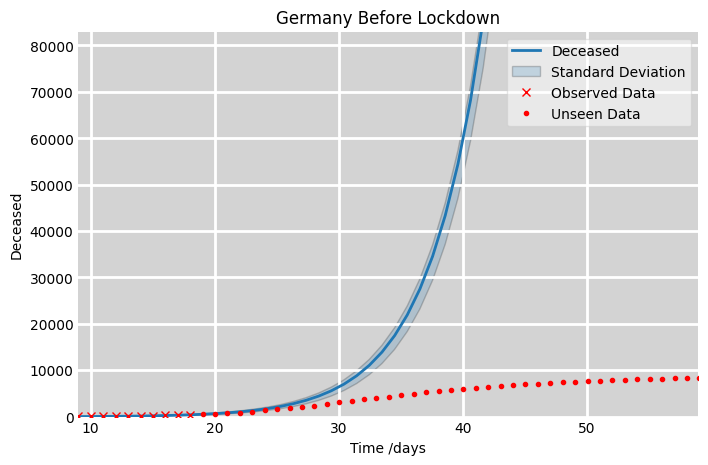

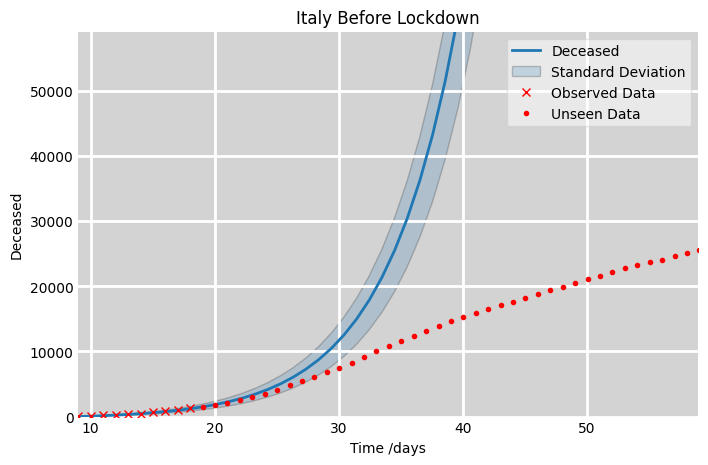

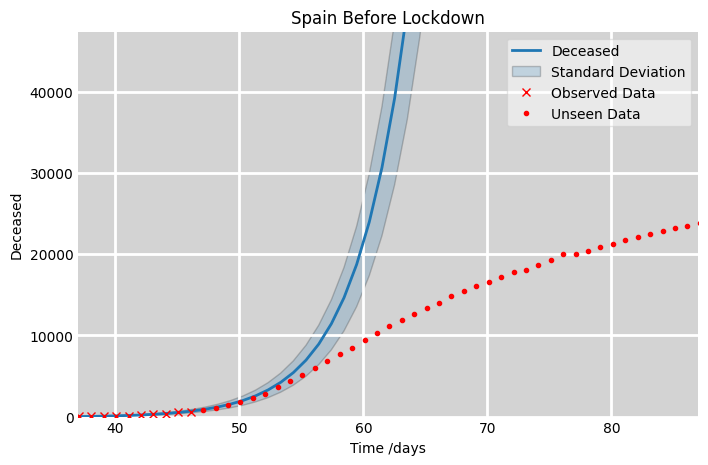

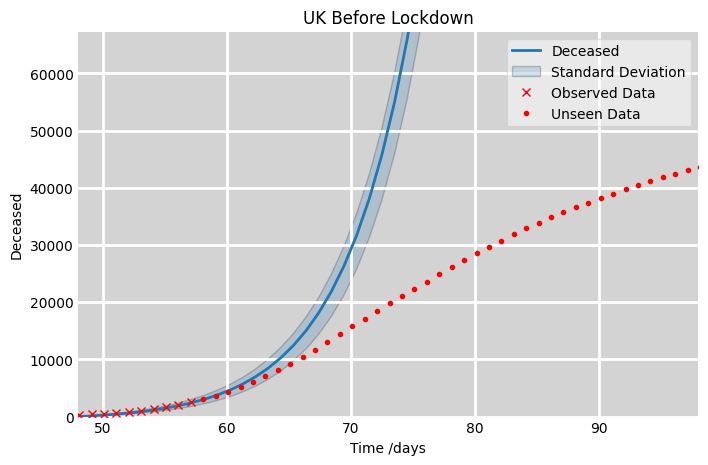

In [21]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-5
    obvData_end = timeTot(firstDate,addTime(startDate,5))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,50, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+40], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-5, False)
    ax1.set_title(country + " Before Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,0)
    plt.savefig('results/first_q/'+country+'.png')


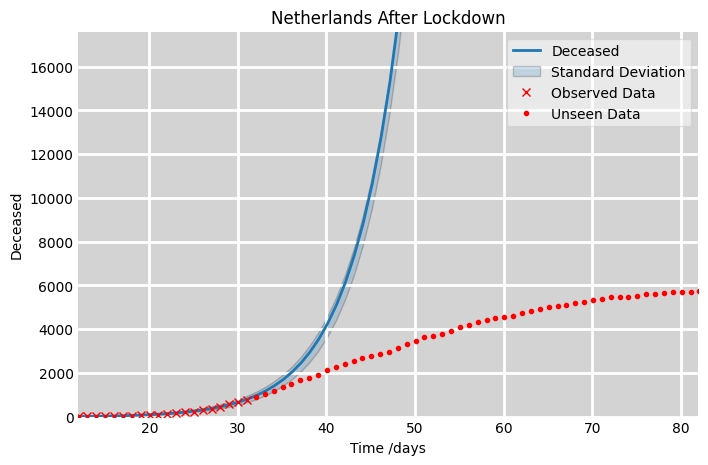

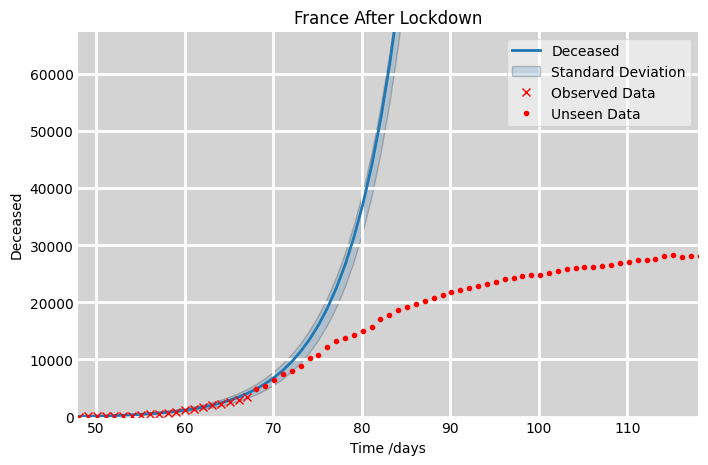

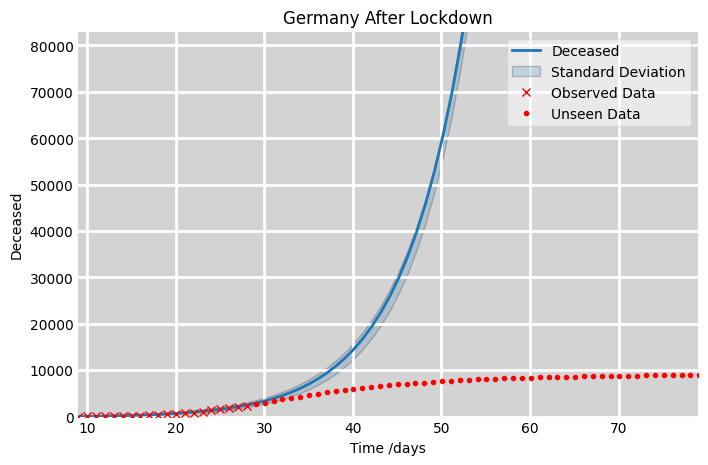

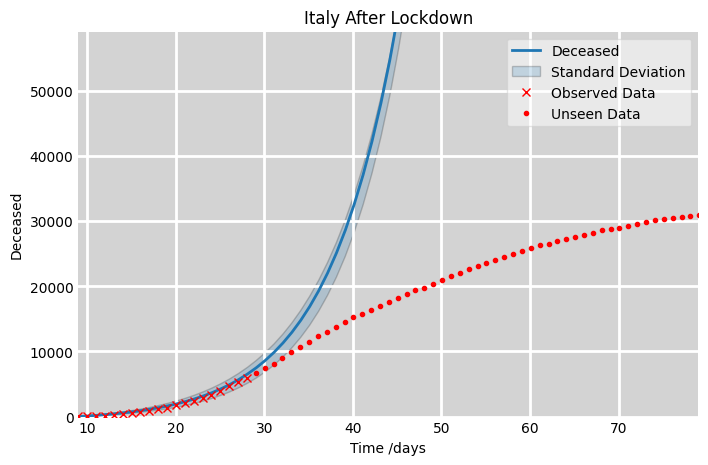

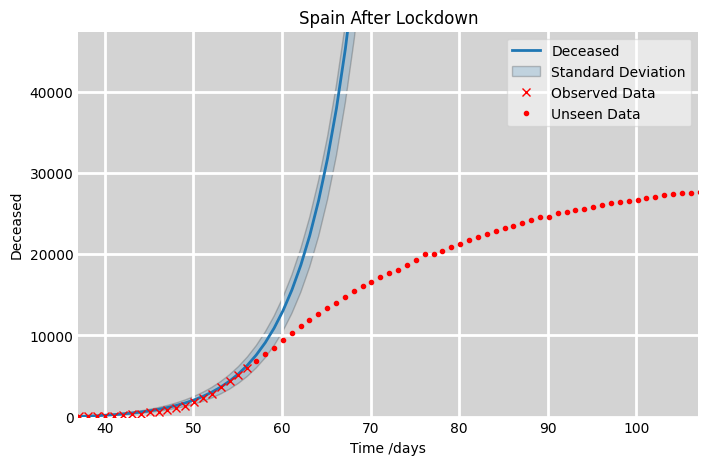

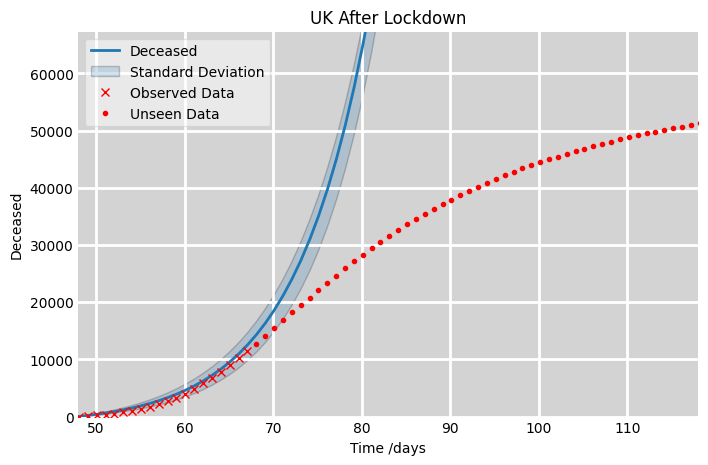

In [22]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    # before
    obvData_start = timeTot(firstDate,startDate)-5
    obvData_end = timeTot(firstDate,addTime(startDate,15))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-5, False)
    sird_deaths[country] = {
        'deaths':graph,
        'date': obvData_end+30
    }
    ax1.set_title(country + " After Lockdown")
    final_graph =plotRealData(ax1, realData, obvData_start, obvData_end, graph,14,True)
    plt.savefig('results/first_q/'+country+'.png')

### Quantifying difference

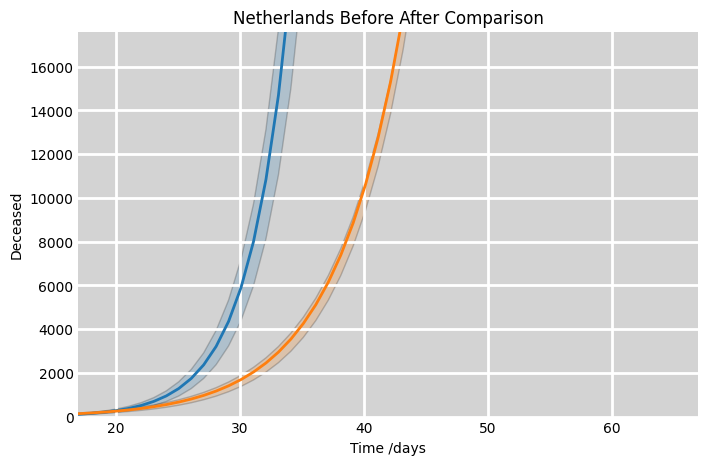

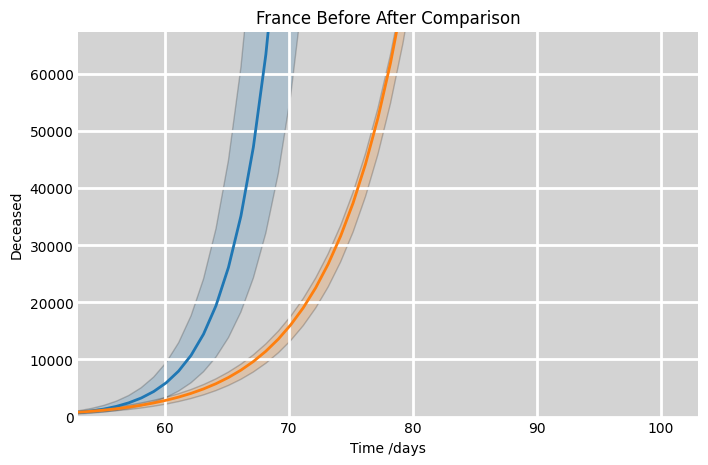

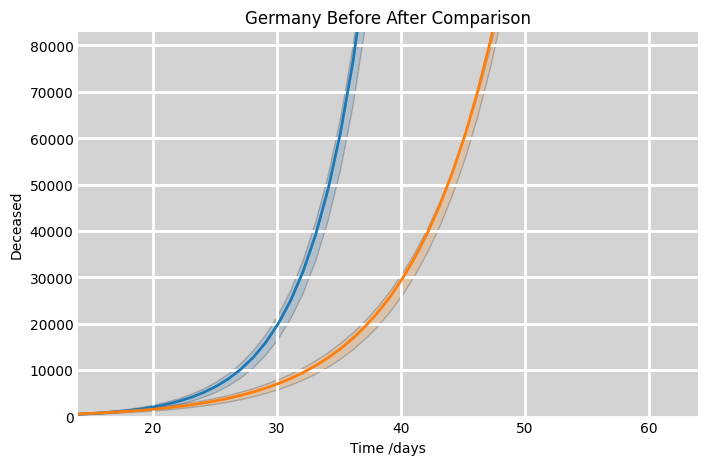

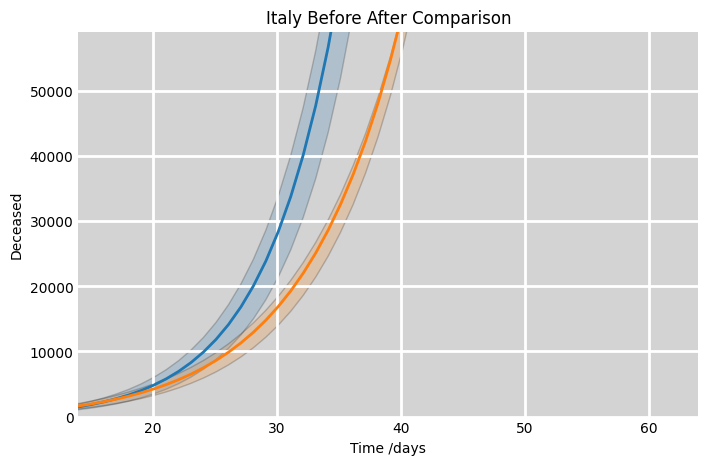

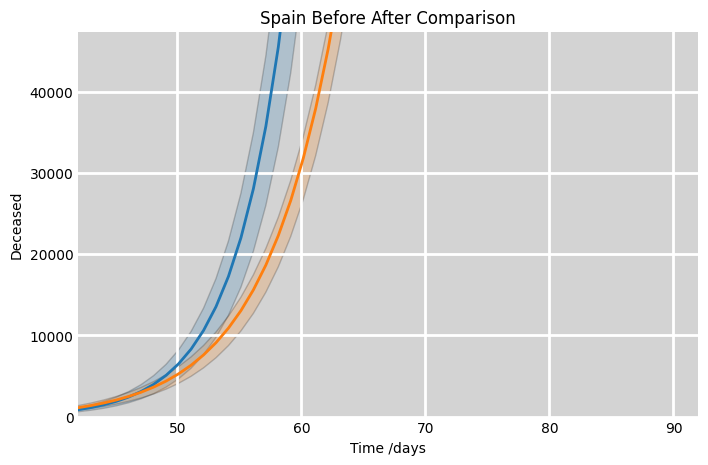

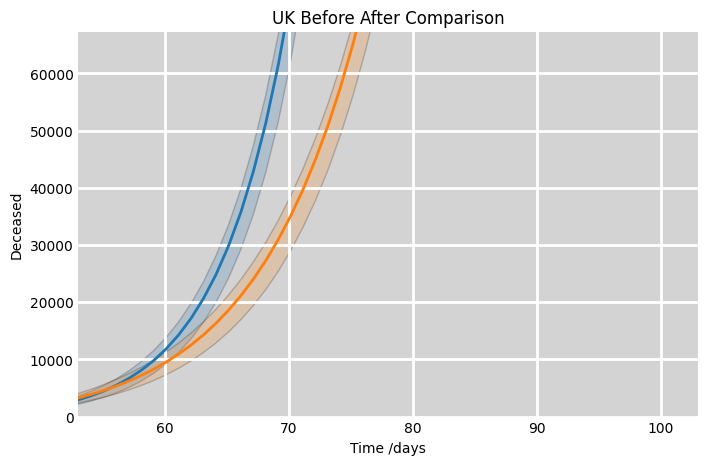

In [23]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
sird_deaths = {}
for country in country_names:
    fig, ax1 = plt.subplots(1,1, figsize=(8,5))    
    ax1.set_facecolor('lightgrey')
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    
    pop = dataset[country]['pop']
    startDate = dataset[country]['fLock'][0]
    realData = pd.read_csv('../processed_data/cumDeath'+country+'.csv')
    firstDate = realData.loc[0]['date']
    
    offset=0
    # before
    obvData_start = timeTot(firstDate,startDate)
    obvData_end = timeTot(firstDate,addTime(startDate,0))
    df = pd.read_csv('mcmc_data/'+country+"/fLock_before.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    sird_deaths[country+str("_before")] = graph
    df = pd.read_csv('mcmc_data/'+country+"/fLock_after.csv")
    graph = plotSIRD(ax1,200, pop, df.loc[3][1], df.loc[0][1], df.loc[1][1], df.loc[2][1], [0,pop/1000], [obvData_start,obvData_end+50], [df.loc[0][2], df.loc[1][2], df.loc[2][2]], timeTot(firstDate,startDate)-10, False)
    sird_deaths[country+str("_after")] = graph
    ax1.set_title(country + " Before After Comparison")
    plt.savefig('results/first_q/'+country+'.png')

In [20]:
country_names = ['Netherlands', 'France','Germany','Italy','Spain','UK']
for country in country_names:
    print(country)
    print(sird_deaths[country+str("_before")][30])
    print(sird_deaths[country+str("_after")][30])
    print(100-(sird_deaths[country+str("_after")][30]/sird_deaths[country+str("_before")][30])*100)
    

Netherlands
49058.767889598734
6145.233699508021
87.47373005099276
France
273061.4427859253
26701.13463873525
90.22156538604816
Germany
49077.44038600225
12685.853570088648
74.15135453211843
Italy
104256.23686579964
20313.617856487723
80.51568091543938
Spain
118984.41159195104
45278.077267926965
61.94621071606837
UK
125886.72248779518
50999.528140515475
59.487762384583554
